# Modelo de reconhecimento criança ou adulto


# 1. Instalação das bibliotecas.

In [ ]:
!pip install tensorflow matplotlib -q

# 2. Importação das bibliotecas

In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

# 3. Comunicação com o drive


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Caminho para o arquivo ZIP no Drive
zip_path = '/content/drive/MyDrive/UTFPr/Periodo 8/Processamento de imagens/Projeto modelo/archive.zip'

# Copia o arquivo para o ambiente local do Colab
!cp "{zip_path}" /content/dataset.zip

# Descompacta o arquivo no diretório "dataset"
!unzip -q /content/dataset.zip -d /content/dataset

# Verificar estrutura do dataset descompactado
!ls /content/dataset

test  train


In [ ]:
# Prepara o dataset
# Configuração de caminhos
base_dir = '/content/dataset'
# caminho de treino
train_dir = os.path.join(base_dir, 'train')
# caminho de teste
test_dir = os.path.join(base_dir, 'test')

In [ ]:
#verificar dados
!ls /content/dataset
!ls /content/dataset/train
!ls /content/dataset/test

test  train
adults	children
adults	children


Define as classes do dataset

In [ ]:
# Classes do dataset
classes = [ 'adults', 'children']


In [ ]:
# Criar Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Dividir 20% para validação
    horizontal_flip=True, # transforma as imagens para o treino
    rotation_range=20,
    zoom_range=0.2
)
# convertendo as imagens para 224 pixels alem de criar as categorias de treino e validação
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 544 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Classes detectadas: {'adults': 0, 'children': 1}
Número de amostras de treino: 544
Número de amostras de validação: 136
Número de amostras de teste: 120


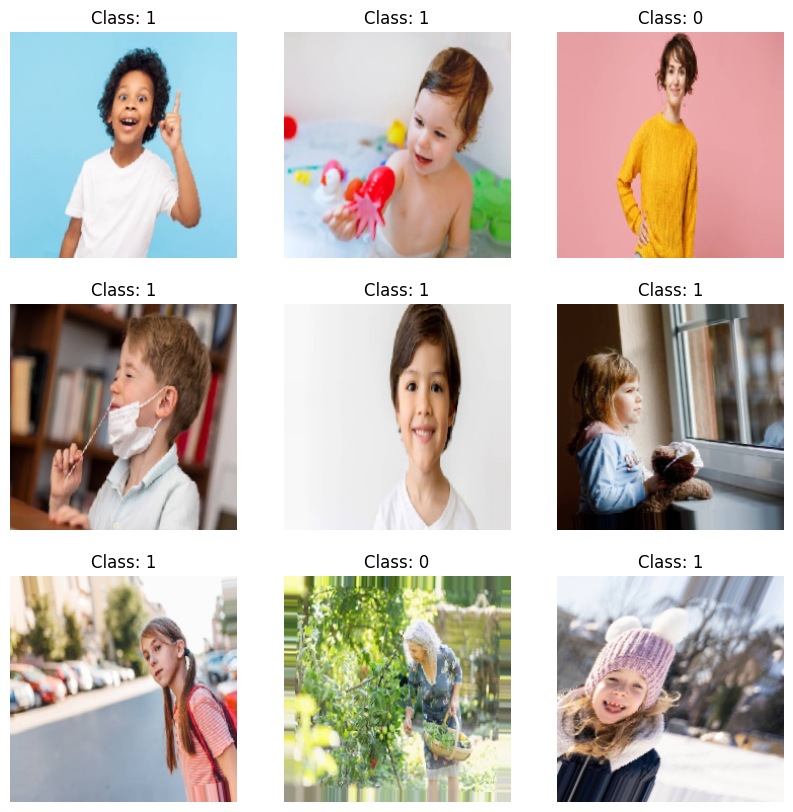

In [ ]:
# Exibir classes e exemplos carregados
print(f"Classes: {train_generator.class_indices}")
print(f"Imagens para treino: {train_generator.samples}")
print(f"Imagens para validação: {val_generator.samples}")
print(f"imagens para teste: {test_generator.samples}")

# Exibir algumas imagens de exemplo
x, y = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(f"Class: {np.argmax(y[i])}")
    plt.axis("off")
plt.show()


In [ ]:
# Construir o modelo com TensorFlow
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas customizadas para classificação
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'), #camada densa totalmente conectada com 128 neuronios
    tf.keras.layers.Dropout(0.2), # poara evitar o overfting
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Treinar o modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10 # quantidade de epocas para o treino
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5470 - loss: 0.9065 - val_accuracy: 0.6985 - val_loss: 0.5775
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7435 - loss: 0.5061 - val_accuracy: 0.8824 - val_loss: 0.3643
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8238 - loss: 0.3978 - val_accuracy: 0.8309 - val_loss: 0.3947
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8620 - loss: 0.3359 - val_accuracy: 0.8235 - val_loss: 0.3713
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8707 - loss: 0.3211 - val_accuracy: 0.8088 - val_loss: 0.3382
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8659 - loss: 0.3241 - val_accuracy: 0.8382 - val_loss: 0.3440
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8848 - loss: 0.2990 - val_accuracy: 0.8382 - val_loss: 0.3693
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8986 - loss: 0.2591 - val_accuracy: 0.7941 - val_loss:

In [ ]:
#  Avaliar o modelo
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7908 - loss: 0.4755
Loss: 0.45703259110450745, Accuracy: 0.800000011920929


In [ ]:
# Visualizar a acurácia e a perda ao longo do treinamento
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

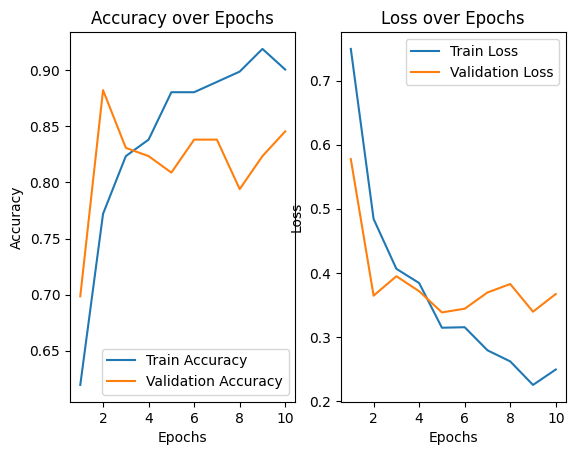

In [ ]:
# Acurácia
time = range(1, len(history.history['accuracy']) + 1)
plt.subplot(1, 2, 1)
plt.plot(time, history.history['accuracy'], label='Train Accuracy')
plt.plot(time, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(time, history.history['loss'], label='Train Loss')
plt.plot(time, history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Salvar o modelo
model.save('/content/face_classifier_model.h5')

In [ ]:
#  Fazer previsões em uma imagem individual
def predict_image(image_path, model, class_names):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Carregar e pré-processar a imagem
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a previsão
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Exibir a imagem e o resultado
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} ({predictions[0][predicted_class] * 100:.2f}%)")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


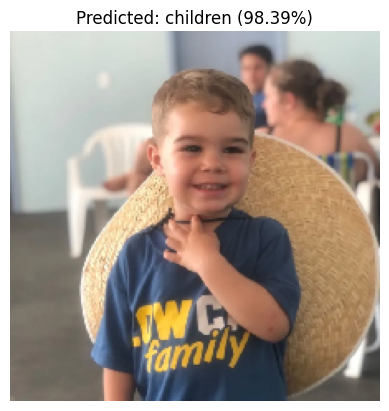

In [ ]:
# teste com imagem unica após o treino
image_path = '/content/drive/MyDrive/fotos vanessa/samuca.png'  # Substitua por uma imagem real
# chama a função que verifica a imagem conforme o modelo treinado
predict_image(image_path, model, classes)
